In [97]:
import sklearn 
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn

In [99]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Train",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Val",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Test",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )

Found 11108 files belonging to 6 classes.
Found 2495 files belonging to 6 classes.
Found 280 files belonging to 6 classes.


In [100]:
class_names=train_ds.class_names
class_names

['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Septoria Leaf Spot',
 'Yellow Leaf Curl Virus']

Text(0.5, 1.0, 'Bacterial Spot')

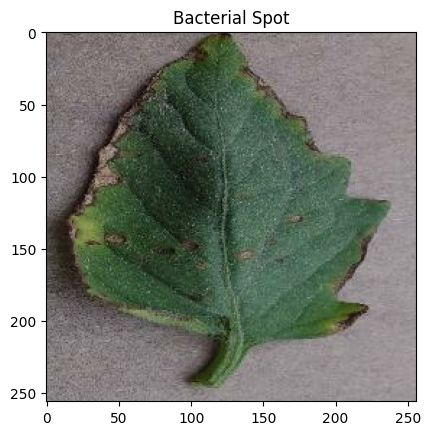

In [103]:
iterator = train_ds.as_numpy_iterator()
# Get the first batch of images and labels
batch = next(iterator)

# Assuming the first element of the batch is the image
image = batch[0][0]
label = batch[1][0] # Get the label for the first image

plt.imshow(image.astype("uint8")) # Corrected the type to "uint8"
plt.title(class_names[label]) # Access class names from train_ds and use label index

In [105]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [107]:
from tensorflow.keras import models, layers
reshape_resize = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

In [109]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Randomly flip images horizontally
    layers.RandomRotation(0.1),                # Randomly rotate images by 10%
    layers.RandomZoom(0.1),                    # Randomly zoom images
    layers.RandomContrast(0.1),                # Adjust contrast slightly
   layers.RandomTranslation(0.1, 0.1),        # Random shift in width and height
    ])



In [111]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [113]:
base_model = tf.keras.applications.MobileNetV2(
      input_shape=(256, 256, 3),
      include_top=False,  # Remove final dense layers of MobileNetV2
      weights='imagenet'  # Load pretrained weights
      )
base_model.trainable = False  # Freeze the base model layers


C:\Users\LC\AppData\Local\Temp\ipykernel_10804\1966742154.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [115]:
                                            # Build the complete model
model = models.Sequential([
    data_augmentation,
    reshape_resize,
    base_model,
    layers.GlobalAveragePooling2D(),         # Flattening
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Output lay
    ])
model.build()

In [117]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [119]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=15,verbose=1,batch_size=32)


Epoch 1/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.6858 - loss: 0.8287 - val_accuracy: 0.7936 - val_loss: 0.5583
Epoch 2/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.8723 - loss: 0.3539 - val_accuracy: 0.7756 - val_loss: 0.6316
Epoch 3/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8887 - loss: 0.3139 - val_accuracy: 0.8285 - val_loss: 0.4705
Epoch 4/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.8998 - loss: 0.2878 - val_accuracy: 0.8417 - val_loss: 0.4358
Epoch 5/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.9128 - loss: 0.2427 - val_accuracy: 0.8497 - val_loss: 0.4349
Epoch 6/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.9115 - loss: 0.2475 - val_accuracy: 0.8569 - val_loss: 0.4135
Epoch 7/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9164 - loss: 0.2331 - val_accuracy: 0.8814 - val_loss: 0.3451
Epoch 8/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.9187 - loss: 0.2223 - val_accu

In [121]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 501ms/step - accuracy: 0.8866 - loss: 0.4205


[0.41085323691368103, 0.8857142925262451]

In [123]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 348}

In [125]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss =  history.history['loss']
val_loss =  history.history['val_loss']

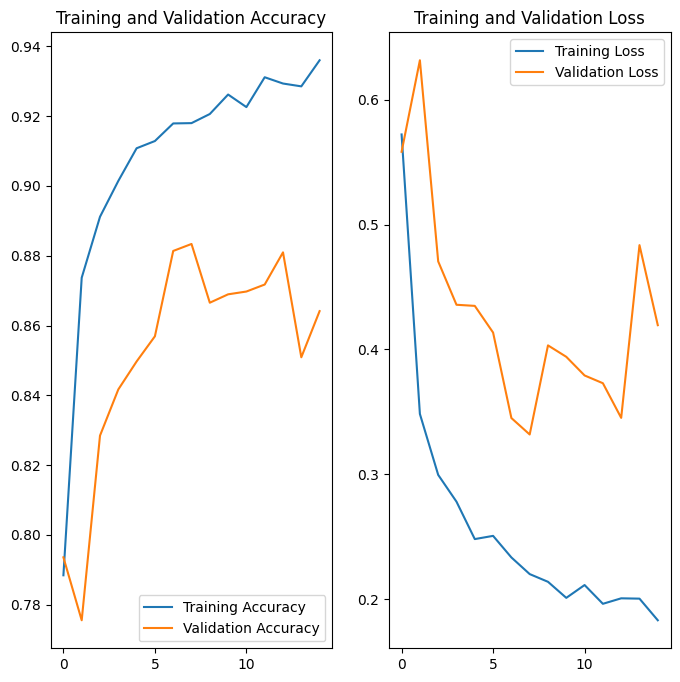

In [127]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Septoria Leaf Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
predicted label: Late Blight


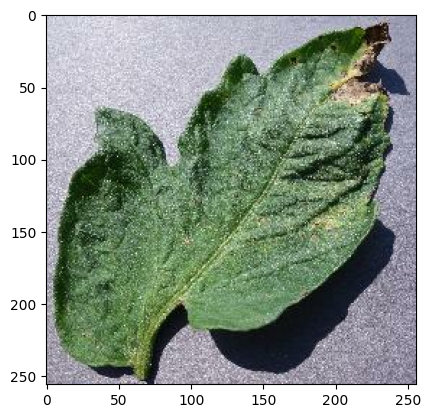

In [91]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [129]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


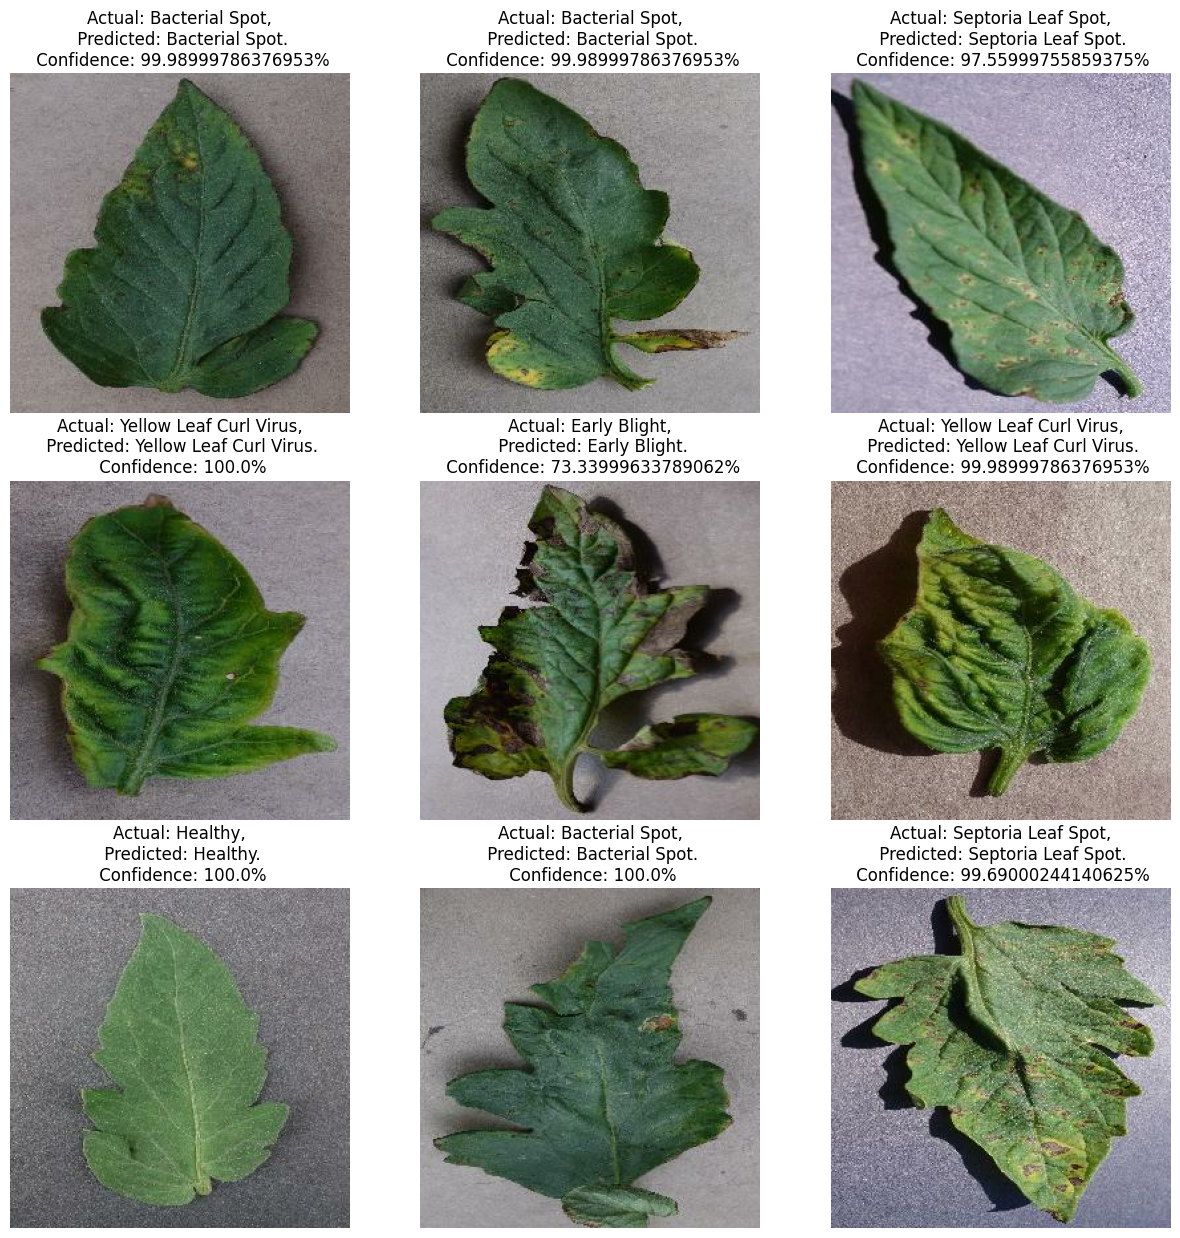

In [133]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
plt.savefig("../images/sample_predictions1.png")

In [137]:
model_version=2
model.save(f'../models/{model_version}.keras')